In [167]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from stellargraph.mapper import FullBatchNodeGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GCN, GraphSAGE
from tensorflow.keras.callbacks import EarlyStopping

**Data Loading**

In [169]:
network = pd.read_csv('data/bio-pathways-network.csv')
graph = nx.from_pandas_edgelist(network, 'Gene ID 1', 'Gene ID 2')

In [170]:
multi_diseases = pd.read_csv('data/all-proteins.csv', index_col=0)
binary_diseases = pd.read_csv('data/binary-classes.csv', index_col=0)
multi_only_diseases = pd.read_csv('data/diseased-proteins.csv', index_col=0)

**GCN**

In [168]:
def gcn_pipeline(G, node_subjects):
    #Train and test split
    train_subjects, test_subjects = model_selection.train_test_split(
        node_subjects, train_size=0.6, test_size=None
    )
    val_subjects, test_subjects = model_selection.train_test_split(
        test_subjects, train_size=0.5, test_size=None
    )
    print(
        "Array shapes:\n train = {}\n val = {}\n test = {}".format(
            train_subjects.shape, val_subjects.shape, test_subjects.shape
        )
    )
    #GCN training generator
    generator = FullBatchNodeGenerator(G, method="gcn")
    train_gen = generator.flow(train_subjects.index, train_subjects.values)
    gcn = GCN(
        layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
    )
    x_inp, x_out = gcn.in_out_tensors()
    predictions = layers.Dense(units=train_subjects.values.shape[1], activation="softmax")(x_out)

    #Model training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=optimizers.Adam(lr=0.01),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    val_gen = generator.flow(val_subjects.index, val_subjects.values)
    es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
    history = model.fit(
        train_gen,
        epochs=200,
        validation_data=val_gen,
        verbose=0,
        shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
        callbacks=[es_callback],
    )
    sg.utils.plot_history(history)

    #Test Metrics
    test_gen = generator.flow(test_subjects.index, test_subjects.values)
    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

Multiclassification over Full Network with GCN

In [171]:
nodes = set(graph.nodes())
drop_rows = []
for n in multi_diseases.index:
    if n not in nodes:
        drop_rows.append(n)
node_multi_diseases = multi_diseases.drop(drop_rows)

In [172]:
G = sg.StellarGraph(graph, node_features=node_multi_diseases)
G.info()

'StellarGraph: Undirected multigraph\n Nodes: 21557, Edges: 342353\n\n Node types:\n  default: [21557]\n    Features: float32 vector, length 30\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [342353]\n        Weights: all 1 (default)\n        Features: none'

Array shapes:
 train = (12934, 30)
 val = (4311, 30)
 test = (4312, 30)
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 905us/step - loss: 0.9222 - acc: 0.1041

Test Set Metrics:
	loss: 0.9222
	acc: 0.1041


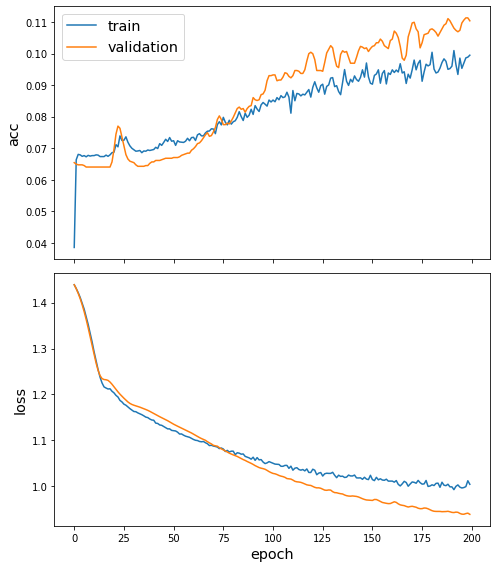

In [173]:
gcn_pipeline(G, node_multi_diseases)

Binary Classification of Presence of Disease with GCN

In [174]:
nodes = set(graph.nodes())
drop_rows = []
for n in binary_diseases.index:
    if n not in nodes:
        drop_rows.append(n)
bin_nodes = binary_diseases.drop(drop_rows)

In [175]:
bG = sg.StellarGraph(graph, node_features=bin_nodes)
bG.info()

'StellarGraph: Undirected multigraph\n Nodes: 21557, Edges: 342353\n\n Node types:\n  default: [21557]\n    Features: float32 vector, length 1\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [342353]\n        Weights: all 1 (default)\n        Features: none'

Array shapes:
 train = (12934, 1)
 val = (4311, 1)
 test = (4312, 1)
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 1ms/step - loss: 2.9111e-08 - acc: 0.2442

Test Set Metrics:
	loss: 0.0000
	acc: 0.2442


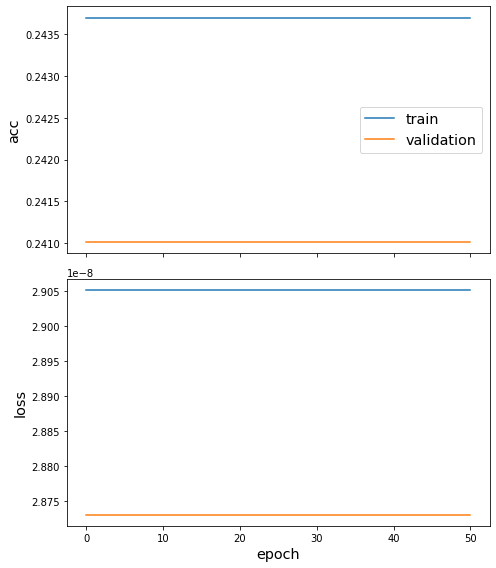

In [176]:
gcn_pipeline(bG, bin_nodes)

Multiclassification of Diseased Network with GCN

In [177]:
dis_graph = nx.read_gml('networks/diseased-ppi')
dis_graph = nx.relabel_nodes(dis_graph, lambda x: int(x), copy=False)

In [178]:
nodes = set(dis_graph.nodes())
drop_rows = []
for n in multi_only_diseases.index:
    if n not in nodes:
        drop_rows.append(n)
dis_nodes_multi = multi_only_diseases.drop(drop_rows)

In [182]:
dG = sg.StellarGraph(dis_graph, node_features=dis_nodes_multi)
dG.info()

'StellarGraph: Undirected multigraph\n Nodes: 5029, Edges: 65674\n\n Node types:\n  default: [5029]\n    Features: float32 vector, length 30\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [65674]\n        Weights: all 1 (default)\n        Features: none'

Array shapes:
 train = (3017, 30)
 val = (1006, 30)
 test = (1006, 30)
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 1ms/step - loss: 3.9095 - acc: 0.4046

Test Set Metrics:
	loss: 3.9095
	acc: 0.4046


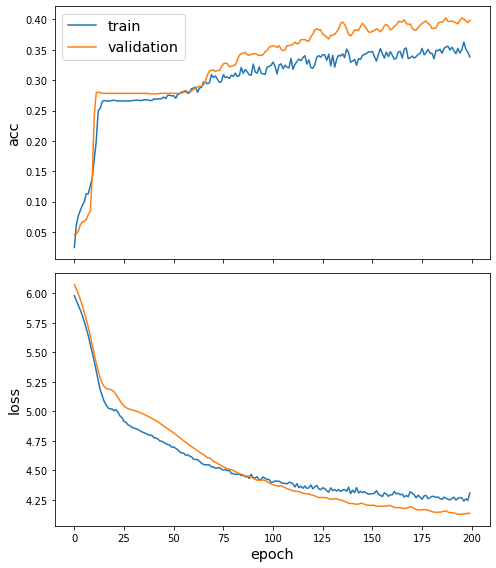

In [183]:
gcn_pipeline(dG, dis_nodes_multi)

**GraphSAGE**

In [186]:
def graphsage_pipeline(G, node_subjects):
    train_subjects, test_subjects = model_selection.train_test_split(
        node_subjects, train_size=0.6, test_size=None
    )
    val_subjects, test_subjects = model_selection.train_test_split(
        test_subjects, train_size=0.5, test_size=None
    )
    print(
        "Array shapes:\n train = {}\n val = {}\n test = {}".format(
            train_subjects.shape, val_subjects.shape, test_subjects.shape
        )
    )
    
    batch_size = 50
    num_samples = [10, 5]

    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

    train_gen = generator.flow(train_subjects.index, train_subjects.values, shuffle=True)

    graphsage_model = GraphSAGE(
        layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )

    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_subjects.values.shape[1], activation="softmax")(x_out)

    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )

    val_gen = generator.flow(val_subjects.index, val_subjects.values)
    history = model.fit(
        train_gen, epochs=20, validation_data=val_gen, verbose=0, shuffle=False
    )
    sg.utils.plot_history(history)
    
    test_gen = generator.flow(test_subjects.index, test_subjects.values)
    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

Multiclassification over Full Network with GraphSAGE

Array shapes:
 train = (12934, 30)
 val = (4311, 30)
 test = (4312, 30)
87/87 [==============================] - 2s 19ms/step - loss: 1.1322 - acc: 0.0638

Test Set Metrics:
	loss: 1.1322
	acc: 0.0638


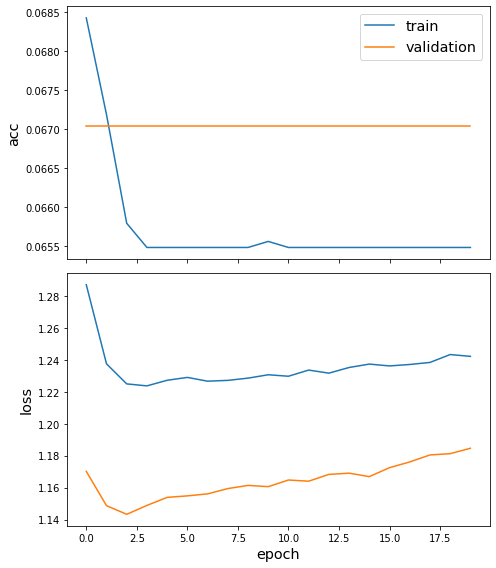

In [187]:
graphsage_pipeline(G, node_multi_diseases)

Binary Classification over Full Network with GraphSAGE

Array shapes:
 train = (12934, 1)
 val = (4311, 1)
 test = (4312, 1)
87/87 [==============================] - 2s 19ms/step - loss: 0.0000e+00 - acc: 0.2474

Test Set Metrics:
	loss: 0.0000
	acc: 0.2474


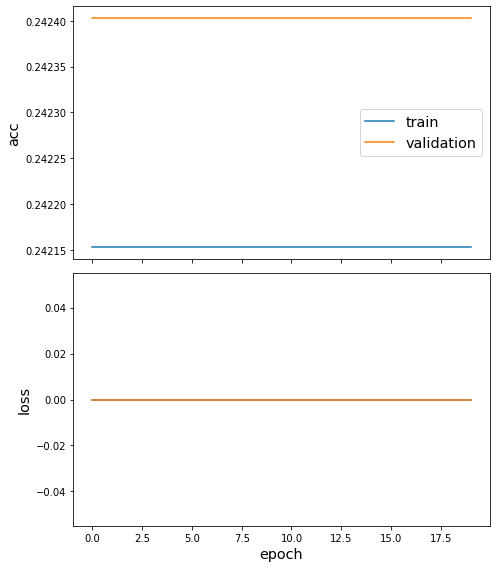

In [188]:
graphsage_pipeline(bG, bin_nodes)

Multiclassification over Diseased Network with GraphSAGE

Array shapes:
 train = (3017, 30)
 val = (1006, 30)
 test = (1006, 30)
21/21 [==============================] - 0s 18ms/step - loss: 5.0096 - acc: 0.2704

Test Set Metrics:
	loss: 5.0096
	acc: 0.2704


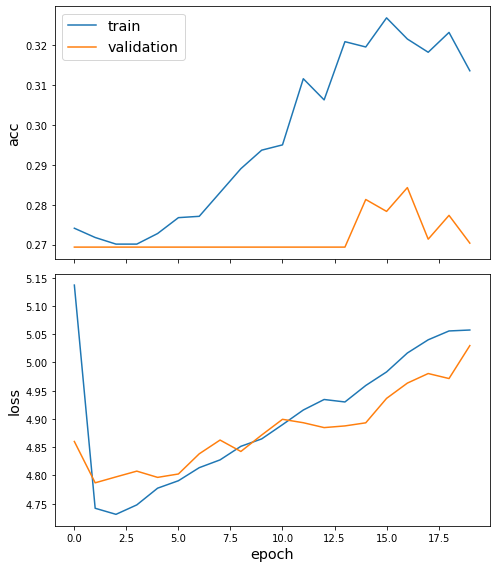

In [189]:
graphsage_pipeline(dG, dis_nodes_multi)